# Import Libraries

Zuerst binden wir wie immer die Benutzen Bibliotheken ein.

In [1]:
from netgen.geom2d import *
import scipy
import scipy.sparse.linalg
import outsource
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import unitary_group
from ngsolve import *
from ngsolve.webgui import Draw

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Implemented QR-Algorithm

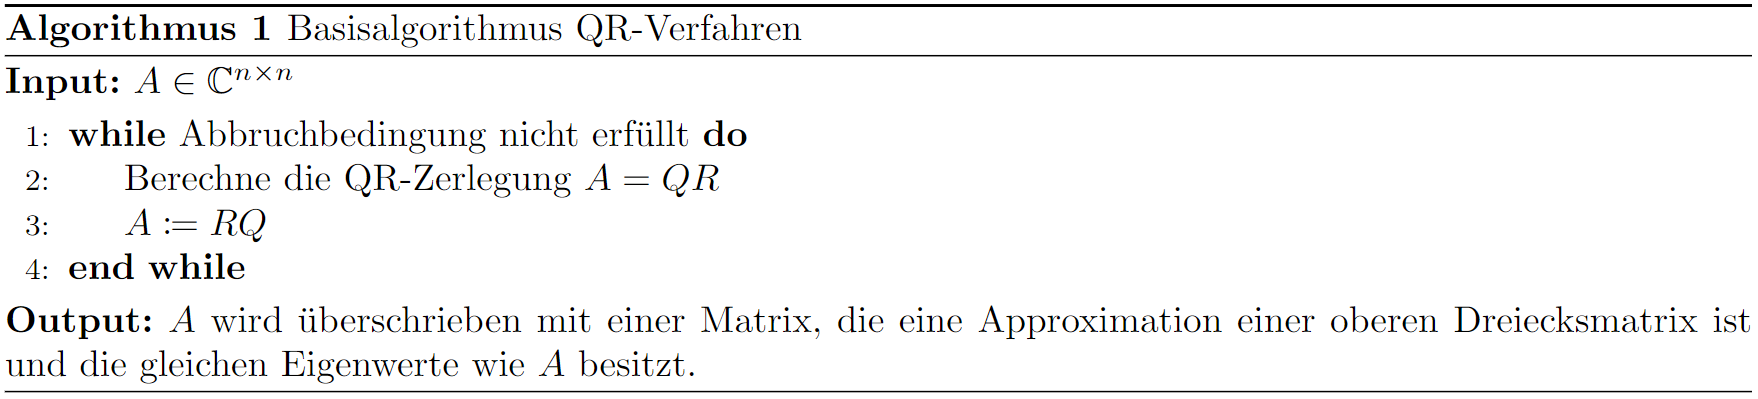


Diese simple Version ist schnell implementiert. Zur Fehler- und Laufzeittestung kommen wir am Ende des Abschnitts.

In [3]:
def QR_simple(A,tol = 1e-7):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):                   #i durchläuft {1,...,n} rückwärts 
        while abs(A[i,i-1]) > tol:              #in der Zeile ist immer labmda_i/lambda_{i-1} am größten
            Q,R = np.linalg.qr(A)               #QR-Zerlegung der  Matrix
            A = R@Q                             #RQ
            count +=1
        A[i,:i-n] = 0                           #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count             

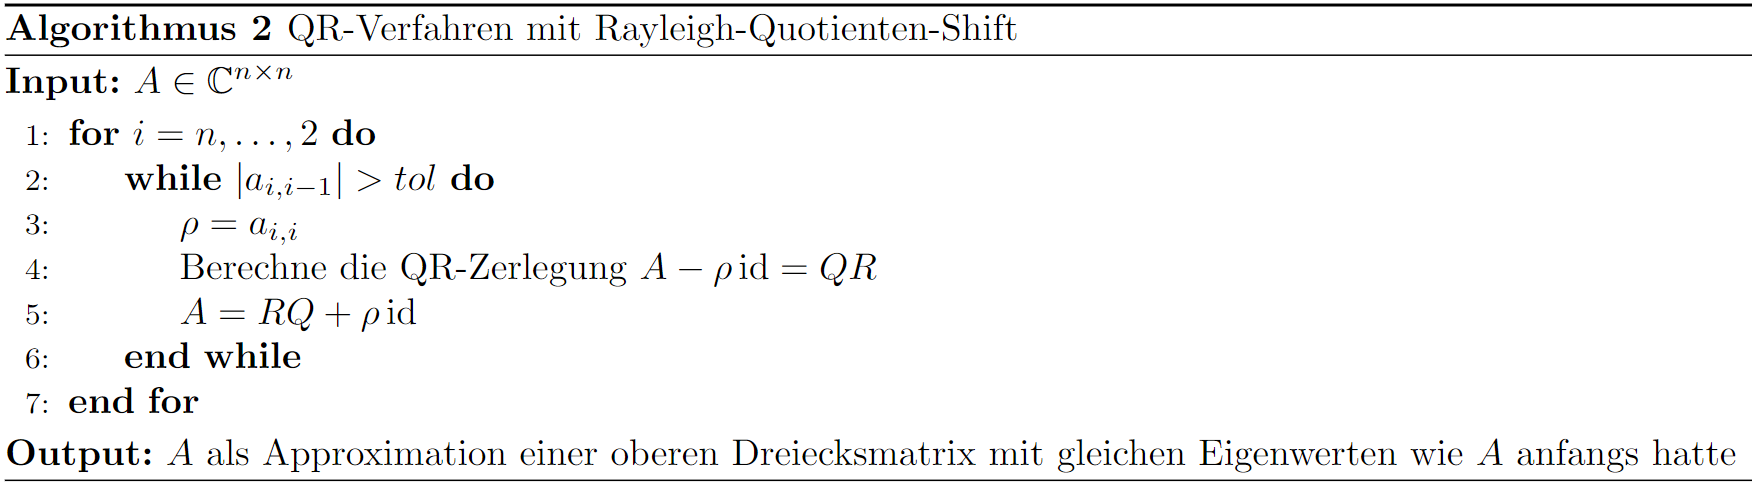

In [4]:
def QR_shift(A,tol=1e-10):
    n = A.shape[1]                                    #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                         #i durchläuft {1,...,n} rückwärts 
        while abs(A[i,i-1]) > tol:                    #in der Zeile ist immer labmda_i/lambda_{i-1} am größten
            rho = A[i,i]                              #Der Shift-Parameter
            Q,R = np.linalg.qr(A-rho*np.identity(n))  #QR-Zerlegung der geshifteten Matrix
            A = R@Q + rho*np.identity(n)              #RQ + Rückshift
            count +=1
        A[i,:i-n] = 0                                 #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count

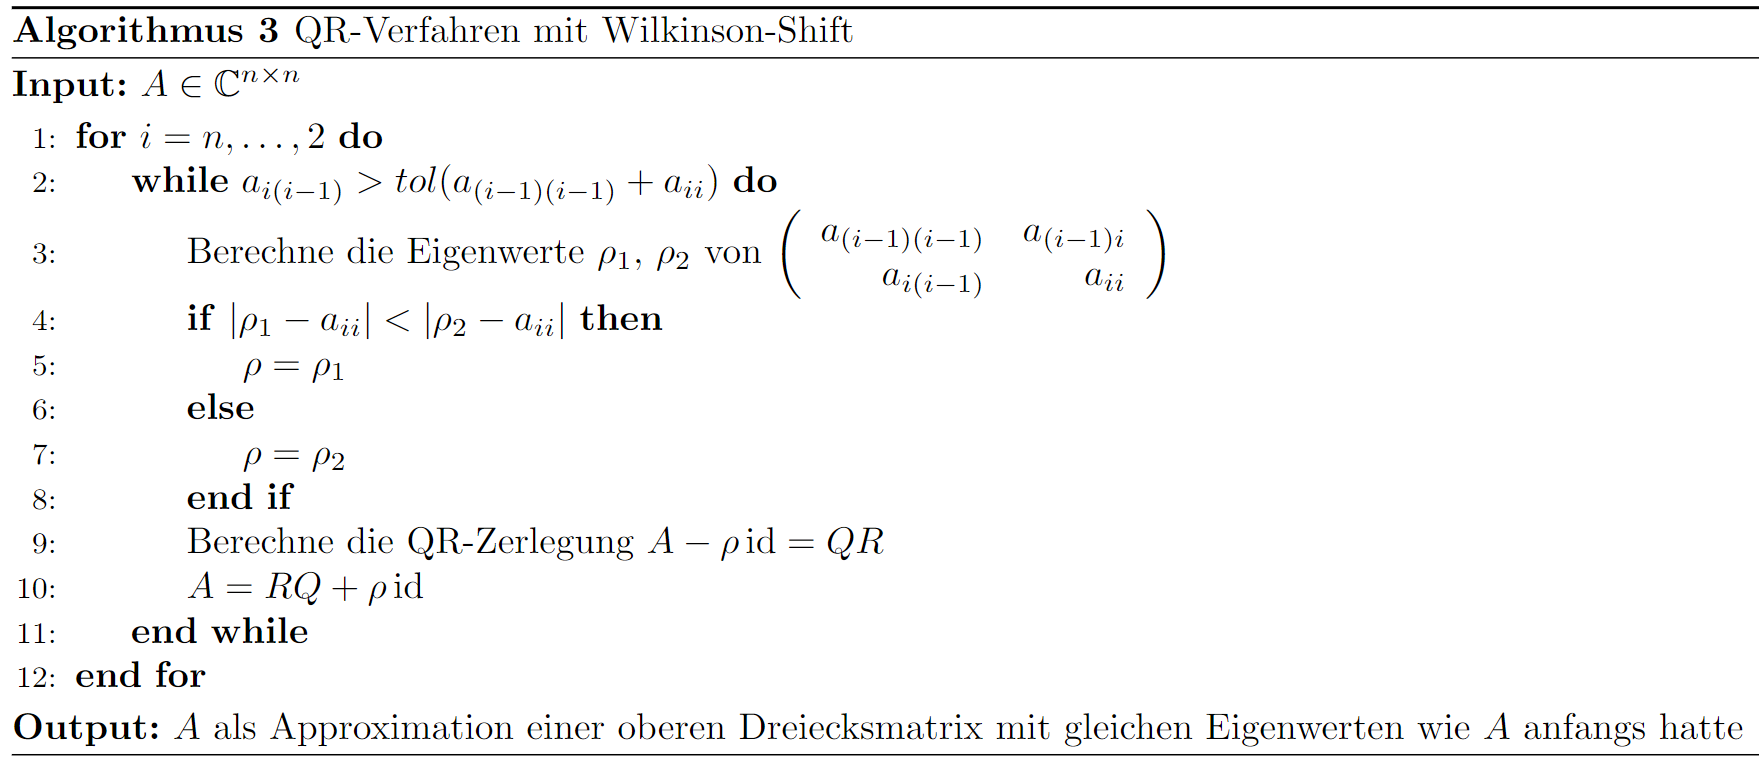

In [5]:
def QR_shift2(A,tol=1e-14):
    n = A.shape[1]                                                #Dimension wird gespeichert
    count = 0
    for i in range(n-1,0,-1):                                     #i durchläuft {1,...,n} rückwärts
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):  #Hier eine alternative Abbruchbedingung
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])             #Eigenwerte werden berechnet
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):           #Es wird überprüft, welcher der Eigenwerte näher am Diagonalelement ist
                rho = w[0]                                        #Wahl für den shift, falls 1 Eigenwert näher am Diagonalelement
            else:
                rho = w[1]                                        #Wahl für den shift, falls 2 Eigenwert näher am Diagonalelement
            Q,R = np.linalg.qr(A-rho*np.identity(n))              #QR-Zerlegung der geshifteten Matrix
            A = R@Q + rho*np.identity(n)                          #RQ + Rückshift
            count += 1
        A[i,:i-n] = 0                                             #Die Zeile wird bis zur Diagonale auf 0 gesetzt um sich aufschaukelnde Fehler zu vermeiden
    return A, sorted(np.diag(A)), count

Zur Testung generieren wir zufällige Eigenwerte und erstellen Matrizen mit diesen durch Ähnlichkeitstransformation. Wir vergleichen einerseits die Anzahl an Schritten die nötig sind (da ja in jedem Schritt eine QR-Zerlegung durchgeführt wird) und andererseits die Fehler gemessen in der $||\cdot||_2$ Norm.

In [6]:
n_arr = [10*i for i in range(1,9)]                                 #Dimension des Problems

k = len(n_arr)
eigv_array = []
for i in range(k):
    eigv_array.append(np.sort(5000*np.random.rand(n_arr[i])-250))  #Eigenwerte werden zufällig generiert

In [7]:
mat_array = []

for i in range(k):
    mat_array.append(outsource.gen_rand_mat(eigv_array[i]))         #Matrizen mit den Eigenwerten werden erstellt

In [8]:
time_1 = [0]*k
time_2 = [0]*k
time_3 = [0]*k

error_1 = [0]*k
error_2 = [0]*k
error_3 = [0]*k
for i in range(k):
    time_1[i], error_1[i] = outsource.runtime_error(QR_simple, mat_array[i], eigv_array[i])
    time_2[i], error_2[i] = outsource.runtime_error(QR_shift, mat_array[i], eigv_array[i])
    time_3[i], error_3[i] = outsource.runtime_error(QR_shift2, mat_array[i], eigv_array[i])

<IPython.core.display.Javascript object>


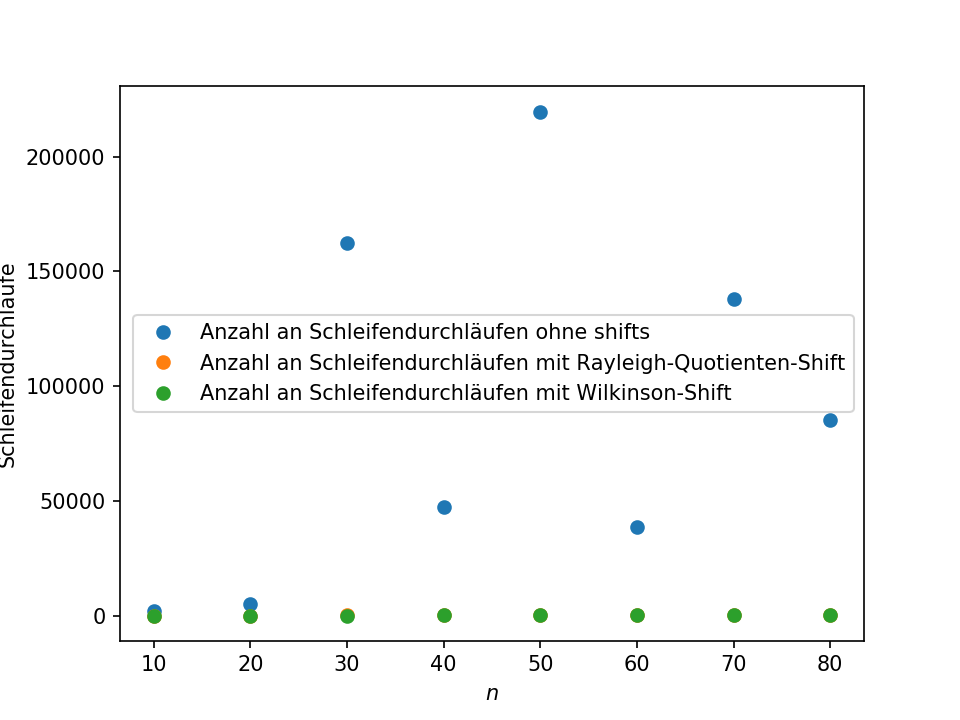

In [130]:
%matplotlib notebook

plt.plot(n_arr, time_1, 'o', label = "Anzahl an Schleifendurchläufen ohne shifts")
plt.plot(n_arr, time_2, 'o', label = "Anzahl an Schleifendurchläufen mit Rayleigh-Quotienten-Shift")
plt.plot(n_arr, time_3, 'o', label = "Anzahl an Schleifendurchläufen mit Wilkinson-Shift")

plt.ylabel("Schleifendurchläufe")
plt.xlabel("$n$")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


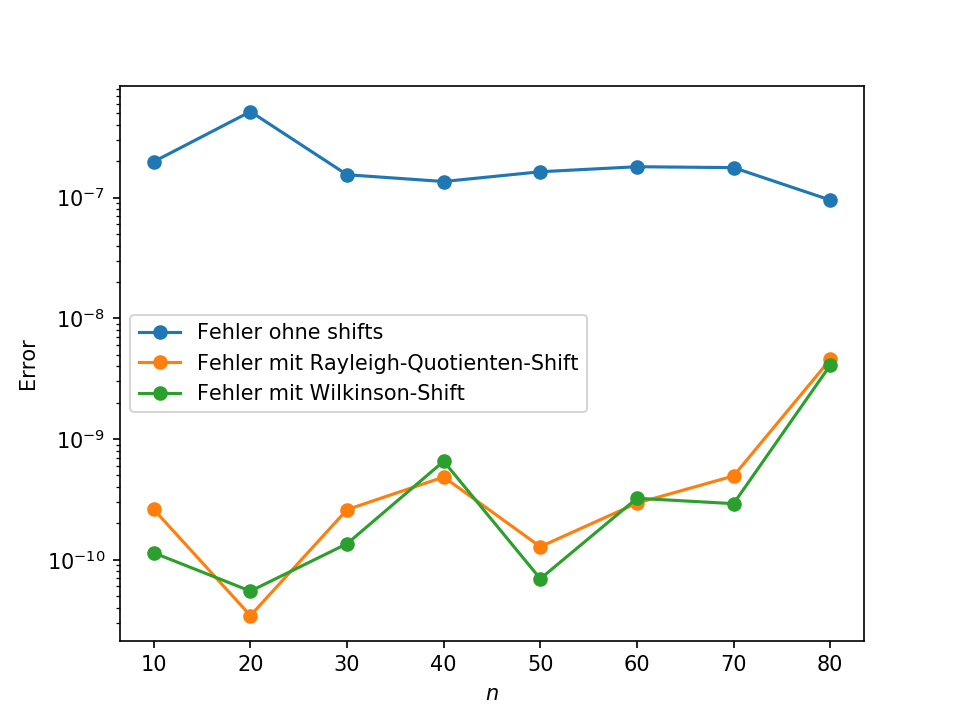

In [131]:
%matplotlib notebook

plt.semilogy(n_arr, error_1, '-o', label = "Fehler ohne shifts")
plt.semilogy(n_arr, error_2, '-o', label = "Fehler mit Rayleigh-Quotienten-Shift")
plt.semilogy(n_arr, error_3, '-o', label = "Fehler mit Wilkinson-Shift")

plt.ylabel("Error")
plt.xlabel("$n$")
plt.legend()
plt.show()

Wir vergleichen nun die QR-Verfahren mit den Shifts nochmal genauer, um zu sehen welcher davon effizienter ist.

In [11]:
n_shifts = [10*i for i in range(1,50)]

len_shifts = len(n_shifts)

In [12]:
eigv_array_shifts = []
for i in range(len_shifts):
    eigv_array_shifts.append(np.sort(5000*np.random.rand(n_shifts[i])-250)) #Eigenwerte werden zufällig generiert

In [13]:
mat_array_shifts = []

for i in range(len_shifts):
    mat_array_shifts.append(outsource.gen_rand_mat(eigv_array_shifts[i]))

In [14]:
time_shifts1 = [0]*len_shifts
time_shifts2 = [0]*len_shifts

error_shifts1 = [0]*len_shifts
error_shifts2 = [0]*len_shifts

for i in range(len_shifts):
    time_shifts1[i], error_shifts1[i] = outsource.runtime_error(QR_shift, mat_array_shifts[i], eigv_array_shifts[i])
    time_shifts2[i], error_shifts2[i] = outsource.runtime_error(QR_shift2, mat_array_shifts[i], eigv_array_shifts[i])

<IPython.core.display.Javascript object>


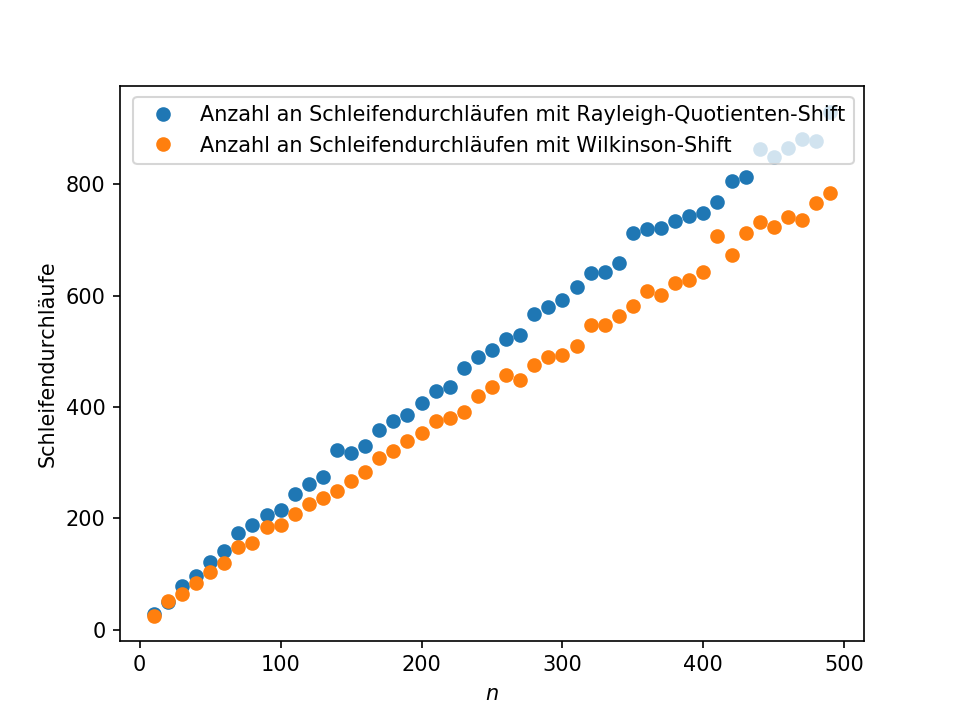

In [132]:
%matplotlib notebook

plt.plot(n_shifts, time_shifts1, 'o', label = "Anzahl an Schleifendurchläufen mit Rayleigh-Quotienten-Shift")
plt.plot(n_shifts, time_shifts2, 'o', label = "Anzahl an Schleifendurchläufen mit Wilkinson-Shift")

plt.ylabel("Schleifendurchläufe")
plt.xlabel("$n$")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


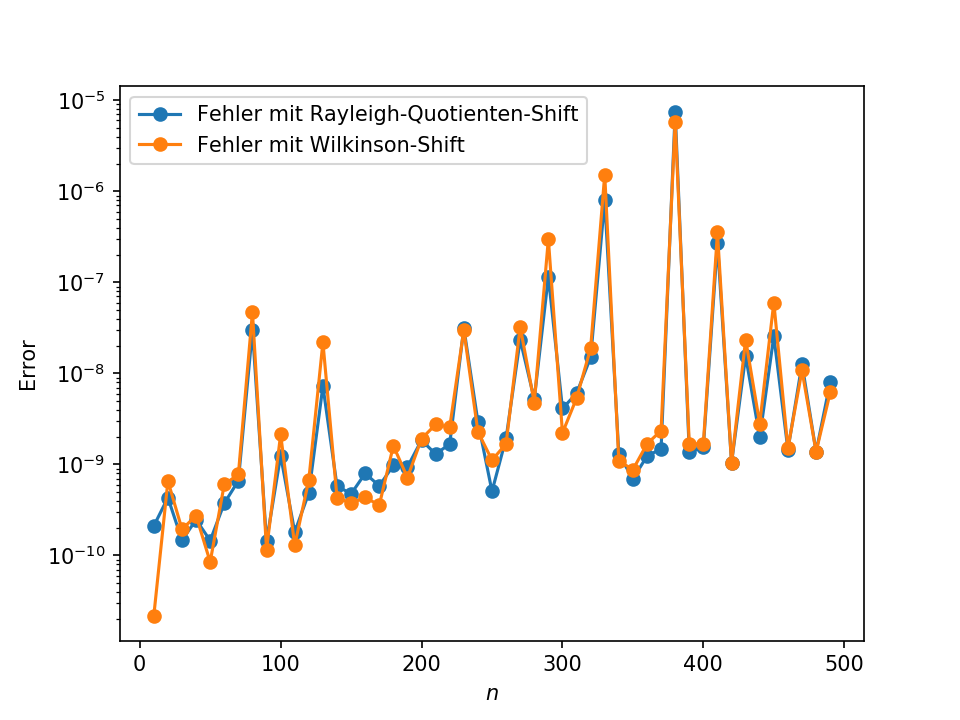

In [69]:
%matplotlib notebook

plt.semilogy(n_shifts, error_shifts1, '-o', label = "Fehler mit Rayleigh-Quotienten-Shift")
plt.semilogy(n_shifts, error_shifts2, '-o', label = "Fehler mit Wilkinson-Shift")

plt.ylabel("Error")
plt.xlabel("$n$")
plt.legend()
plt.show()

## Special-Case: QR-Algorithm applied to a Hessenberg-Matrix

Hier können wir Givens-Rotation verwenden um die QR-Zerlegung durchzufühern und einen speed-up zu bekommen. Als Givens-Rotation bezeichnet man eine $n \times n$ Matrix der Form

$$
G(j,k,c,s)  = \left(\begin{array}{ccc|ccccc|ccc}
    1 &  &  & & & & & & &\\
    & \ddots & & & & & & & & &\\
    & & 1 & & & & & & & \\
    \hline
    & & &  \overline{c} & & & & \overline{s} & & &\\
    & & & & 1 & & & & & &\\
    & & & & & \ddots & & & & &\\
    & & & & &  &1 & & & &\\
    & & & -s & & & & c & & &\\
    \hline
    & & & & & & & & 1 & &\\
    & & & & & & & & & \ddots &\\
    & & & & & & & & & & 1\\
    \end{array}\right)
$$

mit $|c|^2 + |s|^2 = 1$. Der innere Block reicht dabei von der $j$-ten bis zur $k$-ten Zeile sowie Spalte.
Givens-Rotationen sind unitär, da 

$$
\left(\begin{array}{cc}
\overline{c}& \overline{s} \\
-s & c\\
\end{array}\right)\left(\begin{array}{cc}
c & -\overline{s} \\
s & \overline{c}
\end{array}\right)
=
\left(\begin{array}{cc}
|c|^2 + |s|^2 & 0 \\
0 & |c|^2 + |s|^2 \\
\end{array}\right)$$

Wir werden es mit Givens-Rotationen der Form

$$
G(j,j+1,c,s) =
    \left(\begin{array}{ccc|cc|ccc}
    1 & & & & & & & \\
    & \ddots & & & & & & \\
    & & 1 & & & & & \\
    \hline
    & & & \overline{c} & \overline{s} & & & \\
    & & & -s & c & & &\\
    \hline
    & & & & & 1 & & \\
    & & & & & & \ddots & \\
    & & & & & & & 1\\
    \end{array}\right)
$$

zu tun haben.

Multiplikation einer Givens-Rotation der obigen Form von links an eine Matrix $A\in \mathbb{K}^{n\times n}$ hat dann nur in der $j$-ten sowie $j+1$-ten Zeile von $A$ eine Auswirkung. Dort werden die Einträge $a_{j,k}$ sowie $a_{j+1, k}$ ersetzt durch $a_{j,k}\overline{c} + a_{j+1, k}\overline{s}$ bzw. $-a_{j,k}s + a_{j+1, k}c$. Dies können wir nun dazu verwenden um bei einer Hessenberg-Matrix die Einträge unter der Diagonale zu eliminieren und dadurch eine obere Dreiecksmatrix erhalten. 

Dazu müssen wir die Gleichung $-a_{j,j}s + a_{j+1, j}c = 0$ unter der Nebenbedingung $|c|^2 + |s|^2 = 1$ lösen. Die beiden Lösungen unterscheiden sich, wie man sich leicht überzeugen kann, nur durch das Vorzeichen. Eine Lösung ist gegeben durch

$$\left(\begin{array}{c}
    c \\
    s \\
\end{array}\right)
=
\frac{1}{\sqrt{|a_{j,j}|^2 + |a_{j+1,j}|^2}}
\left(\begin{array}{c}
a_{j,j} \\
a_{j+1,j} \\
\end{array}\right)
$$

Um einen over- oder underflow zu vermeiden werden wir jedoch eine andere äquivalente Formel verwenden.

Eine Hessenberg-Matrix $A \in \mathbb{K}^{n\times n}$ können wir dann durch Anwendung von $n-1$ Givens-Rotationen auf eine obere Dreiecksmatrix bringen. Folgende Darstellung aus dem Numerik-Skriptum beschreibt die Vorgehensweise bei $n = 4$:

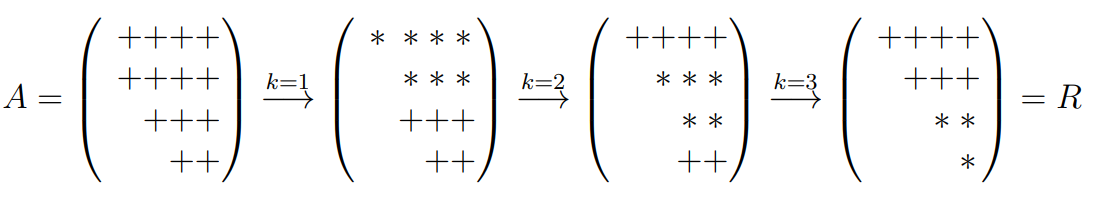

Die spezielle Struktur der Hessenberg-Matrix können wir nun verwenden, um Rechenschritte zu sparen: In der $j$-ten Zeile sind die ersten $j-2$ Einträge bereits $0$ (und damit auch in der $j+1$-ten Zeile). Daher müssen wir die Anwendung der Givens-Rotation erst ab der $j-1$-ten Spalte realisieren.

Um schließlich noch die $Q$-Matrix aus der QR-Zerlegung zu erhalten, bemerken wir zunächst, dass die Multiplikation zweier unitärer Matrizen wieder eine unitäre Matrix liefert. Durch unseren Algorithmus erhalten wir

$$
R = G(n-1,n,c_{n-1},s_{n-1})\cdots G(1,2, c_1, s_1) A
$$

Die Multiplikaton der Givens-Rotationen gibt wieder eine unitäre Matrix, definieren wir also 

$$
\overline{Q}^\top := G(n-1,n,c_{n-1},s_{n-1})\cdots G(1,2, c_1, s_1)
$$

erhalten wir $Q$ durch transponieren und konjugieren des Produktes der Givens-Rotationen, da dann

$$
QR = A
$$

Bei Multiplikation der $l+1$-ten Givens-Rotation mit dem Produkt der $l$ vorhergegangenen können wir wieder verwenden, dass nur in zwei Zeilen eine Änderung passiert. Da das Produkt der Givens-Rotationen jedoch keine Hessenberg-Matrix ist, müssen wir die Rechnung in allen Spalten durchführen.

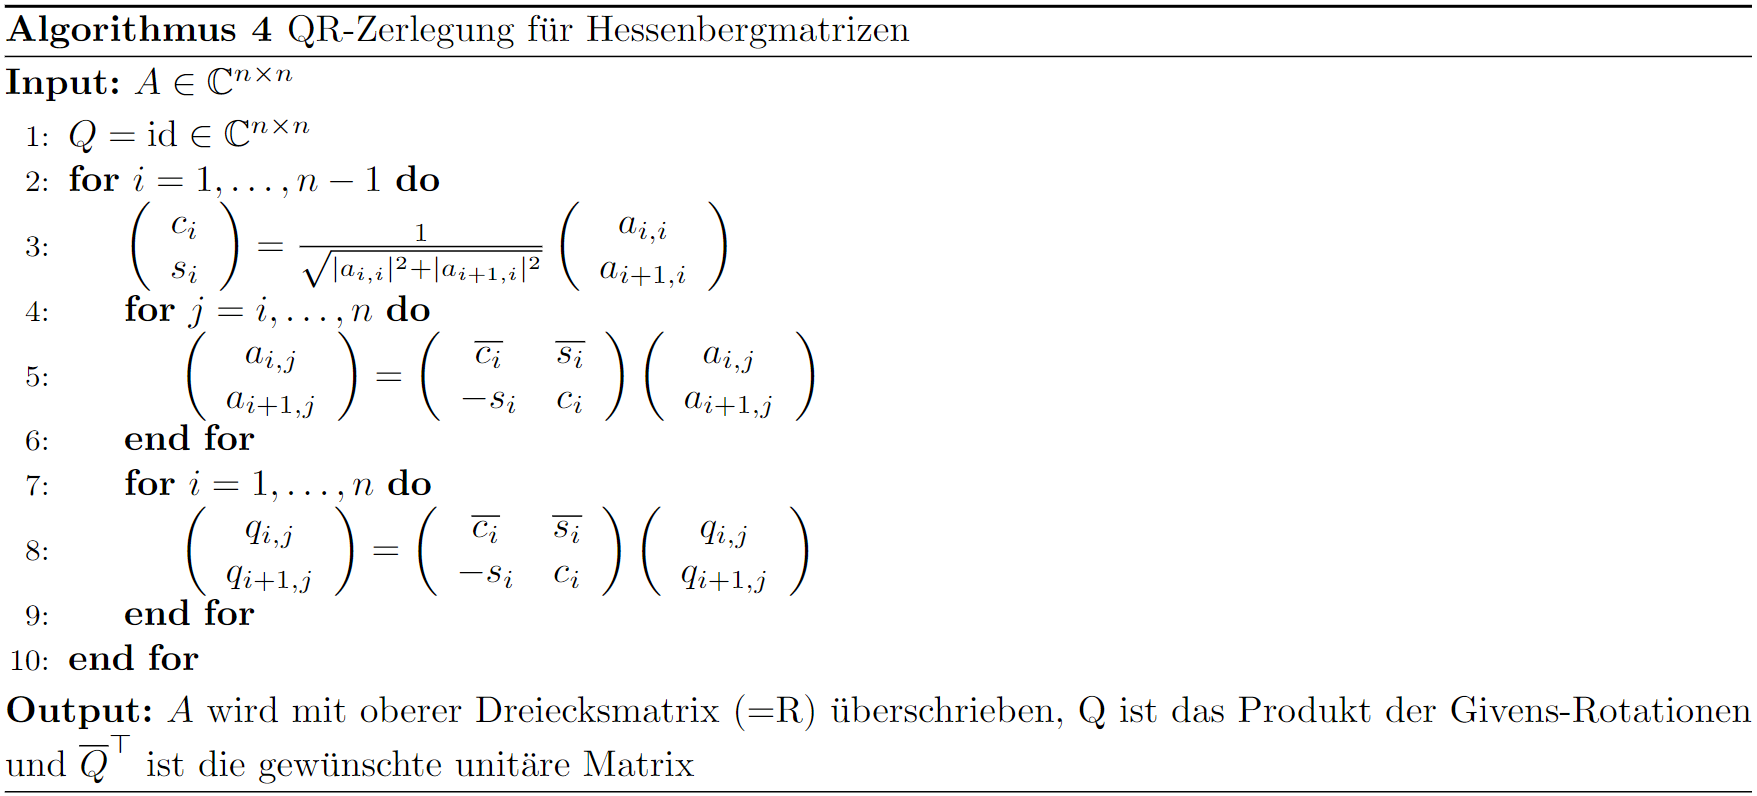

In [17]:
def QR_decomp_hesse(A):
    n = A.shape[0]
    Q = np.eye(n,n)

    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):                     #Überprüfen der Bedingung
            t = A[i+1,i]/abs(A[i,i])                         #Berechnung von t
            root = (1+abs(t)**2)**(1/2)                      #Ausdruck in der Wurzel
            c = A[i,i]/(abs(A[i,i])*root)                    #Berechnung von c
            s = t/root                                       #Berechnung von s
        else:
            t = A[i,i]/abs(A[i+1,i])                         #Berechnung von t
            root = (1+abs(t)**2)**(1/2)                      #Ausdruck in der Wurzel
            s = A[i+1,i]/(abs(A[i+1,i])*root)                #Berechnung von s
            c = t/root                                       #Berechnung von c
            
        for j in range(n):
            if j < i:                                        #Bis zum i-ten Index sind die Einträge a_{i,j} sowie a_{i+1,j} 0
                temp_2 = Q[i,j]                              #Zwischenspeichern des Eintrags, da dieser im nächsten Schritt überschireben wird
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j] #Berechnung des neuen Eintrags    
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]            #Berechnung des neuen Eintrags
            else:
                temp_1 = A[i,j]                              #Zwischenspeichern des Eintrags, da dieser im nächsten Schritt überschireben wird
                A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j] #Berechnung der neuen Einträge  
                A[i+1,j] = -s*temp_1 + c*A[i+1,j]   
                temp_2 = Q[i,j]
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j]     
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]                                
            
    return Q.T.conj(), A

Wir können also nun das QR-Verfahren mit dem Wilkinson-Shift etwas effizienter gestalten, indem wir unsere QR-Zerlegung für Hessebergmatrizen verwenden.

In [18]:
def QR_hesse(A,tol=1e-14):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = QR_decomp_hesse(A-rho*np.identity(n))            #Statt vorimplementierter QR-Zerlegung hier QR-Zerlegung mit Givens-Rotationen
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count

Wir können nun auch die Laufzeit zwischen der QR-Zerlegung speziell für Hessebergmatrizen und der QR-Zerlegung aus dem numpy-linalg Paket vergleichen.

In [19]:
n_arr_1 = [10*i for i in range(1,20)]       #Dimension des Problems

k = len(n_arr_1)
    
mat_array_1 = []

for i in range(k):
    mat_array_1.append(outsource.gen_hess(n_arr_1[i])) #Hesseberg-Matrizen der Dimension n werden erstellt

In [20]:
time_givens = [0]*k
time_vorimplementiert = [0]*k

for i in range(k):
    time_givens[i] = outsource.runtime(QR_decomp_hesse, mat_array_1[i])
    time_vorimplementiert[i] = outsource.runtime(np.linalg.qr, mat_array_1[i])

<IPython.core.display.Javascript object>


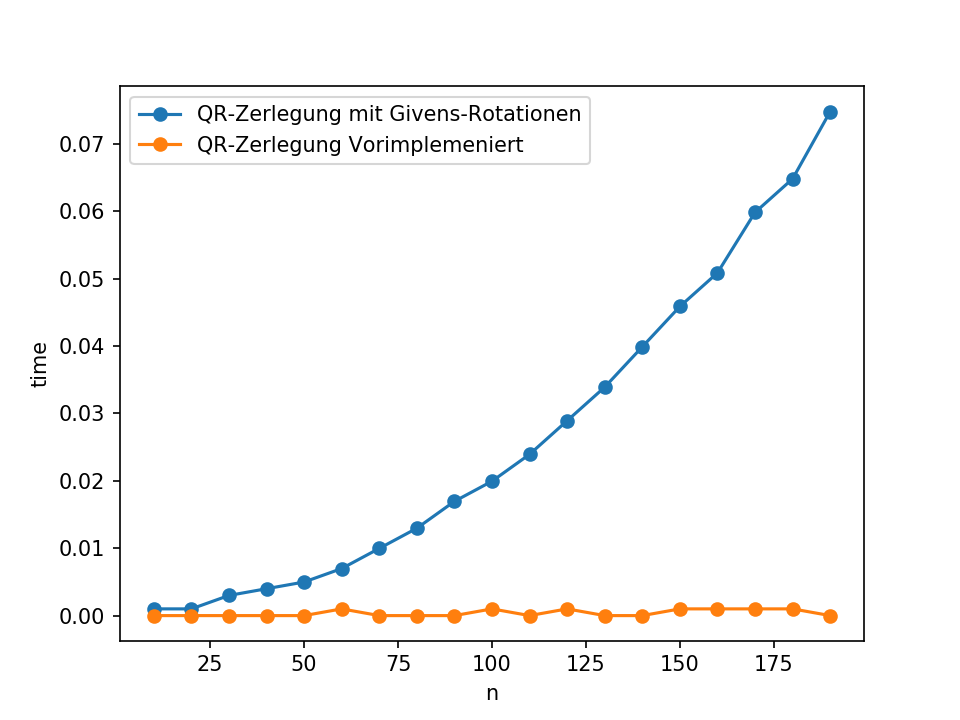

In [68]:
%matplotlib notebook

plt.plot(n_arr_1, time_givens, '-o', label = "QR-Zerlegung mit Givens-Rotationen")
plt.plot(n_arr_1, time_vorimplementiert, '-o', label = "QR-Zerlegung Vorimplemeniert")

plt.xlabel("n")
plt.ylabel("time")
plt.legend()
plt.show()

Wie man erkennt ist der vorimplementierte QR-Algorithmus wohl immer noch um einiges effizienter. Das mag wohl daran liegen, dass dieser auf einer Fortran-Routine basiert und Fortran um einiges besser für numerische Berechnungen geeignet ist als Python.

## Lanczos-Algorithm

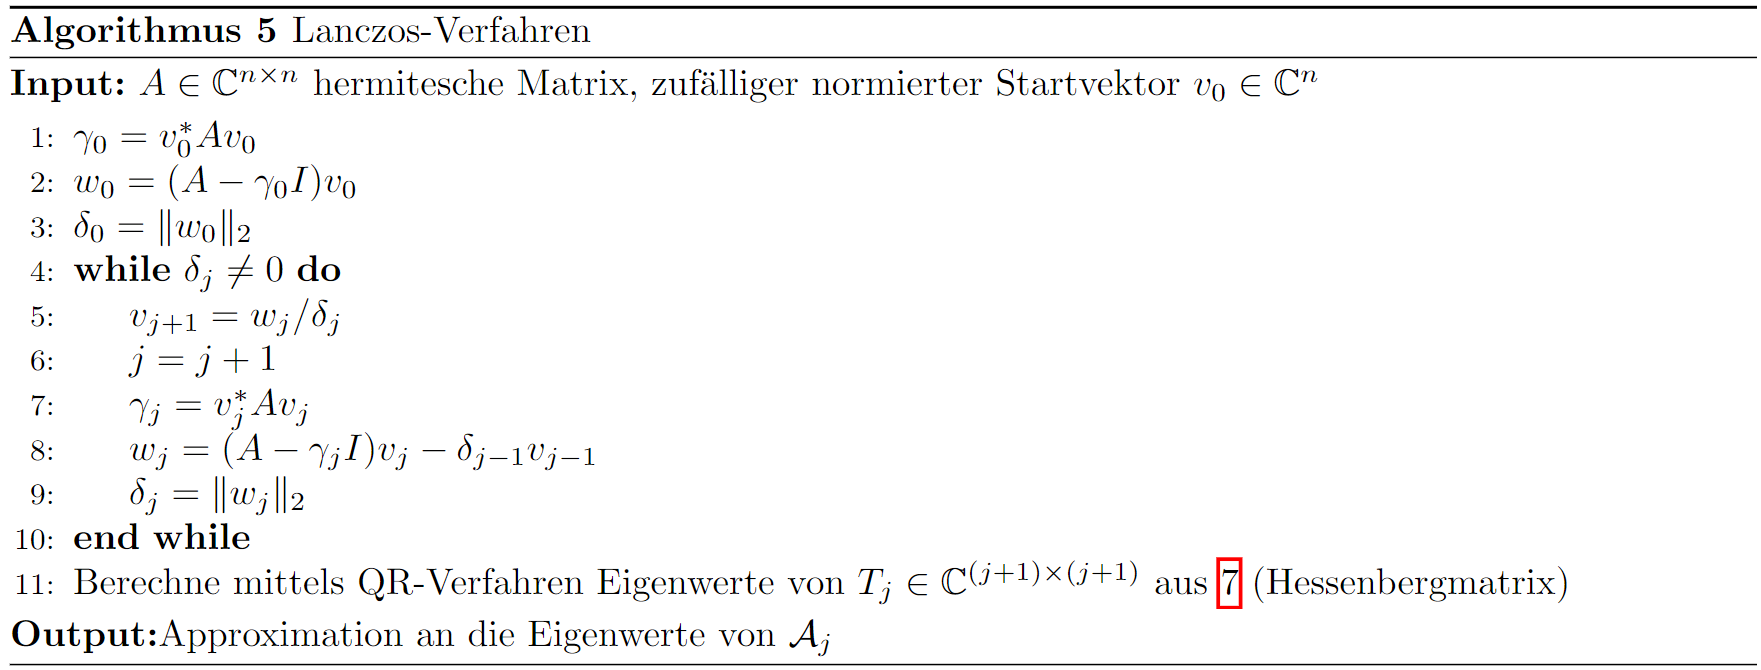

In [78]:
def lanczos(A,m = 0):                                                  #m sei die Anzahl der zu berechnenden Eigenwerte
    n = A.shape[1]
    if m == 0:                                                         #Wird keine Anzahl angegeben werden alle berechnet
        m = n
        
    v0 = np.random.rand(n)                                             #Randomisierter Startvektor wird gewählt
    v = [v0/np.linalg.norm(v0)]                                        #Normieren sowie Listenerstellung
    gam = [v[0].T.conj()@A@v[0]]                                       #Berechnung von gamma und Listenerstellung
    w = (A - gam[0]*np.identity(n))@v[0]                               #Berechnung des Vektors w
    delta = [np.linalg.norm(w)]                                        #Zugehörige Norm sowie Listenerstellung
    j = 0
    while delta[j] > 1e-10 and j < m-1:                                #Sobald delta zu 0 wird haben wir unsere ONB aus Eigenvektoren
        v.append(w/delta[j])                                           #Liste der v wird erweitert
        j +=1
        gam.append(v[j].T.conj()@A@v[j])                               #Berechnung von gamma und hinzufügen zur Liste
        w = (A - gam[j]*np.identity(n))@v[j] - delta[j-1]*v[j-1]       #Berechnung von w
        delta.append(np.linalg.norm(w))                                #Berechnung von delta und hinzufügen zur Liste
    T = np.diag(delta[:-1], -1) + np.diag(gam) + np.diag(delta[:-1], 1)#Erstellen der Tridiagonalmatrix T
    return QR_hesse(T)                                                 #Eigenwerte von T werden mit QR-Verfahren berechnet

Das Lanczos-Verfahren weist in der Praxis einige Eigenheiten auf. Laut Theorie sollten die größten Eigenwerte am schnellsten konvergieren, man sieht in der Anwendung jedoch eine gewisse Symmetrie in der Konvergenz: Der Fehler in den größten $k$ Eigenwerten entspricht ungefähr dem Fehler in den kleinsten $k$.

In [116]:
n_dim = 1000                                              #Dimension des Problems

eigvalues = np.sort(500*np.random.rand(n_dim)-100)        #Eigenwerte werden zufällig generiert

In [117]:
mat_lan = outsource.gen_hermite(eigvalues)

In [118]:
dim_kyrlov = [i for i in range(40,100)]
nr_approx_eigs = 1 
k = len(dim_kyrlov)

In [119]:
error_lanczos = [0]*k
error_lanczos_small = [0]*k
error_lanczos_large = [0]*k

for i in range(k):
    lanczos_approx = lanczos(mat_lan, dim_kyrlov[i])[1]
    length = len(lanczos_approx)
    error_lanczos_small[i] = outsource.error(lanczos_approx[:nr_approx_eigs],eigvalues[:nr_approx_eigs])
    error_lanczos_large[i] = outsource.error(lanczos_approx[:length-nr_approx_eigs-1:-1], eigvalues[:len(eigvalues)-nr_approx_eigs-1:-1])
    error_lanczos[i] = outsource.selective_error(lanczos_approx, eigvalues, nr_approx_eigs)

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


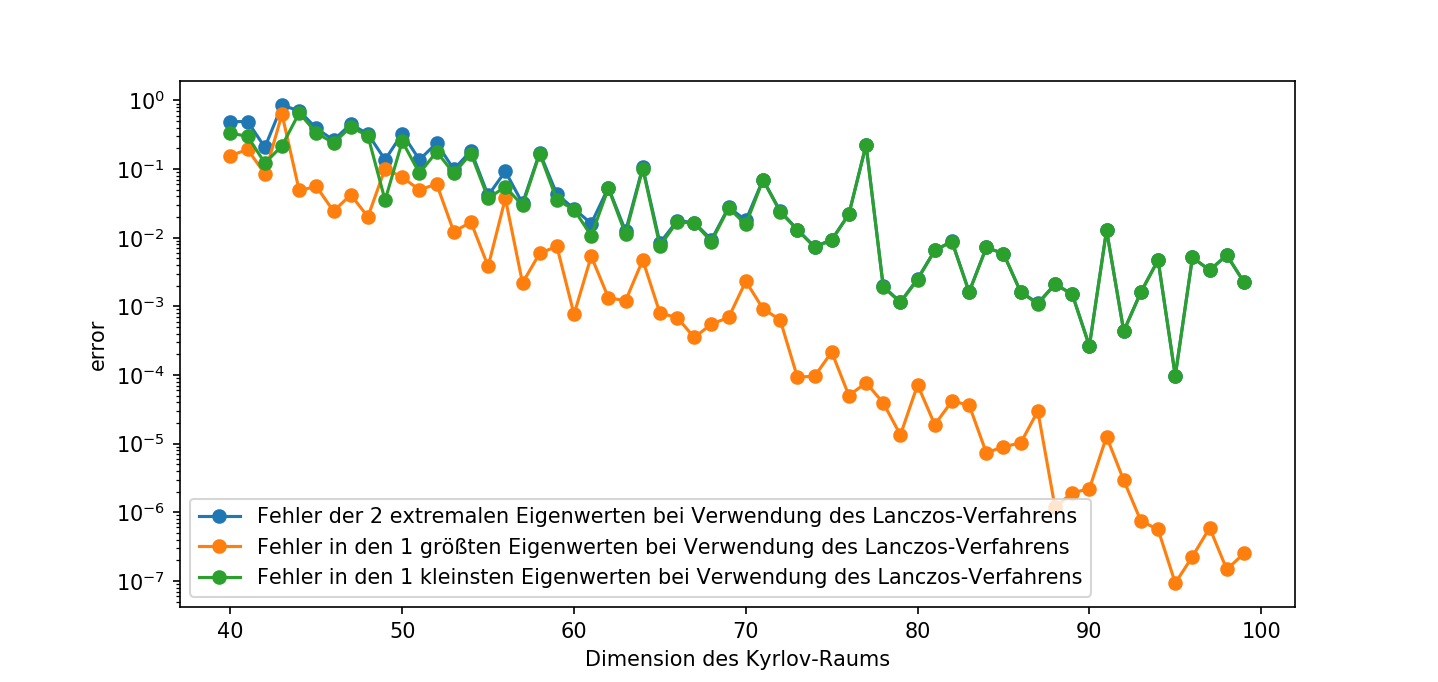

In [133]:
%matplotlib notebook

plt.semilogy(dim_kyrlov, error_lanczos, '-o', label = "Fehler der {nr} extremalen Eigenwerten bei Verwendung des Lanczos-Verfahrens".format(nr = nr_approx_eigs*2))
plt.semilogy(dim_kyrlov, error_lanczos_large, '-o', label = "Fehler in den {nr} größten Eigenwerten bei Verwendung des Lanczos-Verfahrens".format(nr = nr_approx_eigs))
plt.semilogy(dim_kyrlov, error_lanczos_small, '-o', label = "Fehler in den {nr} kleinsten Eigenwerten bei Verwendung des Lanczos-Verfahrens".format(nr = nr_approx_eigs))

plt.xlabel("Dimension des Kyrlov-Raums")
plt.ylabel("error")
plt.legend()
plt.show()

Sofern die Eigenwerte nicht gleichverteilt sind, sondern sich einige vom Cluster unterscheiden, erhalten wir wesentlich schnellere Konvergenz.

In [121]:
for j in range(int(n_dim*0.01)):                            #Das 1-e % an Eigenwerten von oben sowie unten werden weiter Verschoben
    eigvalues[j] = 1.2*eigvalues[j]-100
    eigvalues[n_dim-j-1] = 1.2*eigvalues[n_dim-j-1]+100
mat_lan_2 = outsource.gen_hermite(eigvalues)

In [122]:
error_lanczos_2 = [0]*k
error_lanczos_large_2 = [0]*k
error_lanczos_small_2 = [0]*k
for i in range(k):
    lanczos_approx = lanczos(mat_lan_2, dim_kyrlov[i])[1]
    error_lanczos_small_2[i] = outsource.error(lanczos_approx[:nr_approx_eigs],eigvalues[:nr_approx_eigs])
    error_lanczos_large_2[i] = outsource.error(lanczos_approx[:len(lanczos_approx)-nr_approx_eigs-1:-1], eigvalues[:len(eigvalues)-nr_approx_eigs-1:-1])
    error_lanczos_2[i] = outsource.selective_error(lanczos_approx, eigvalues, nr_approx_eigs)

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


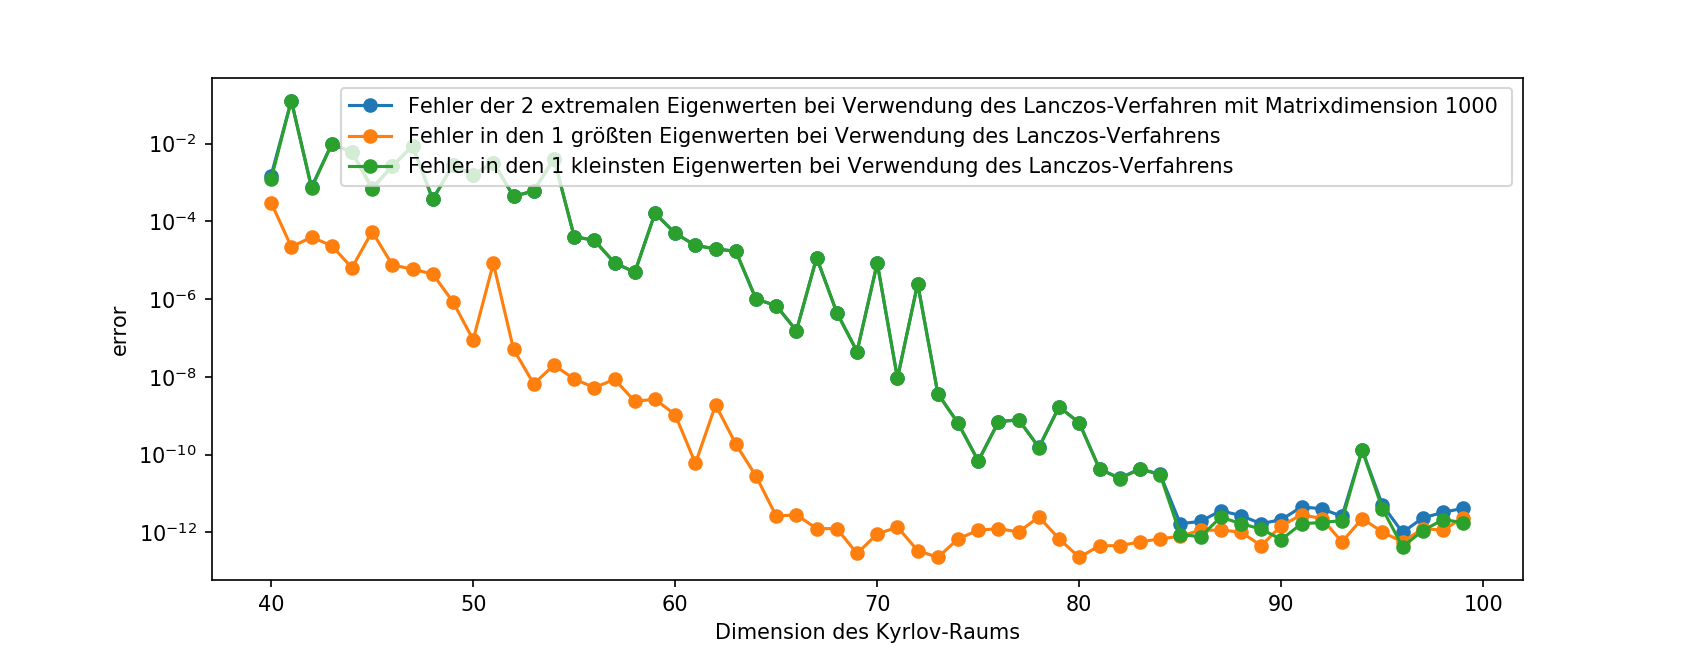

In [134]:
%matplotlib notebook

plt.semilogy(dim_kyrlov, error_lanczos_2, '-o', label = "Fehler der {nr} extremalen Eigenwerten bei Verwendung des Lanczos-Verfahren mit Matrixdimension {dim} ".format(nr = nr_approx_eigs*2, dim = n_dim))
plt.semilogy(dim_kyrlov, error_lanczos_large_2, '-o', label = "Fehler in den {nr} größten Eigenwerten bei Verwendung des Lanczos-Verfahrens".format(nr = nr_approx_eigs))
plt.semilogy(dim_kyrlov, error_lanczos_small_2, '-o', label = "Fehler in den {nr} kleinsten Eigenwerten bei Verwendung des Lanczos-Verfahrens".format(nr = nr_approx_eigs))

plt.xlabel("Dimension des Kyrlov-Raums")
plt.ylabel("error")
plt.legend()
plt.show()

Falls wir nicht an allen Eigenwerten interessiert sind, können wir einige davon nun wesentlich Zeiteffizienter berechnen.

In [47]:
n_arr_3 = [10*i for i in range(5,50)]                                 #Dimension des Problems

m = len(n_arr_3)
eigv_array_3 = []
for i in range(m):
    eigv_array_3.append(np.sort(5000*np.random.rand(n_arr_3[i])-2500)) #Eigenwerte werden zufällig generiert
    
mat_array_3 = []

for i in range(m):
    mat_array_3.append(outsource.gen_hermite(eigv_array_3[i]))

In [48]:
time_lanczos_2 = [0]*m
error_lanczos_2 = [0]*m

time_QR_shifts = [0]*m
error_QR_shifts = [0]*m

for i in range(m):
    time_lanczos_2[i], error_lanczos_2[i] = outsource.runtime_error(lanczos,mat_array_3[i], eigv_array_3[i], 50)
    time_QR_shifts[i], error_QR_shifts[i] = outsource.runtime_error(QR_shift2,mat_array_3[i], eigv_array_3[i])

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


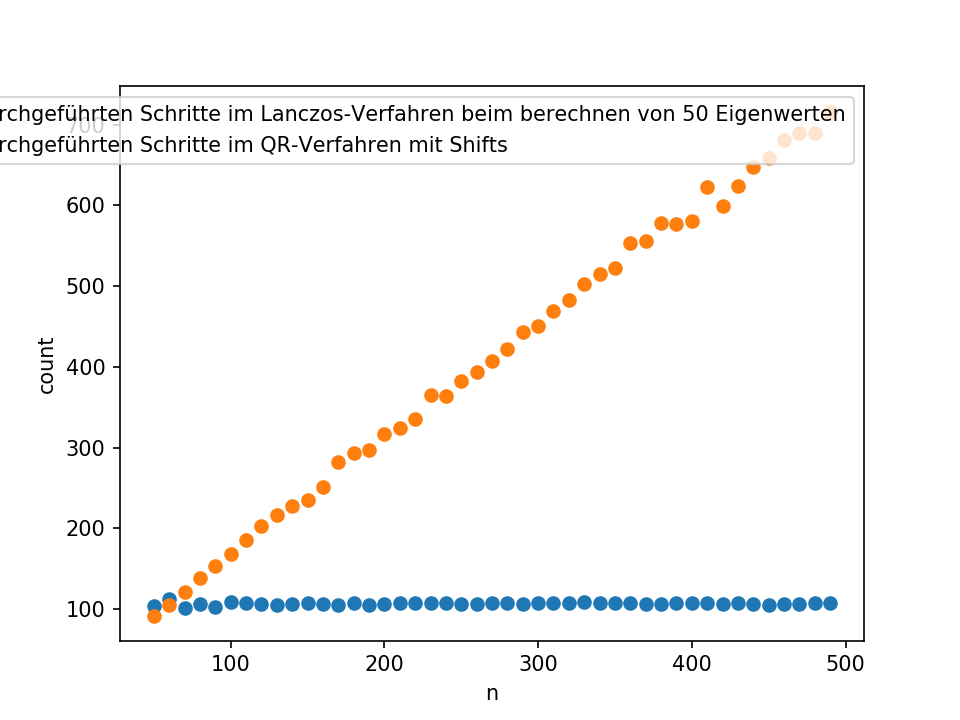

In [62]:
%matplotlib notebook

plt.plot(n_arr_3, time_lanczos_2,'o', label = "Zahl der durchgeführten Schritte im Lanczos-Verfahren beim berechnen von 50 Eigenwerten")
plt.plot(n_arr_3, time_QR_shifts, 'o', label = "Zahl der durchgeführten Schritte im QR-Verfahren mit Shifts")

plt.xlabel("n")
plt.ylabel("count")

plt.legend()
plt.show()

Da wir bei dem verallgemeinerten Problem keine Hermitschen Matrizen erhalten, verwenden wir das Arnoldi-Verfahren.

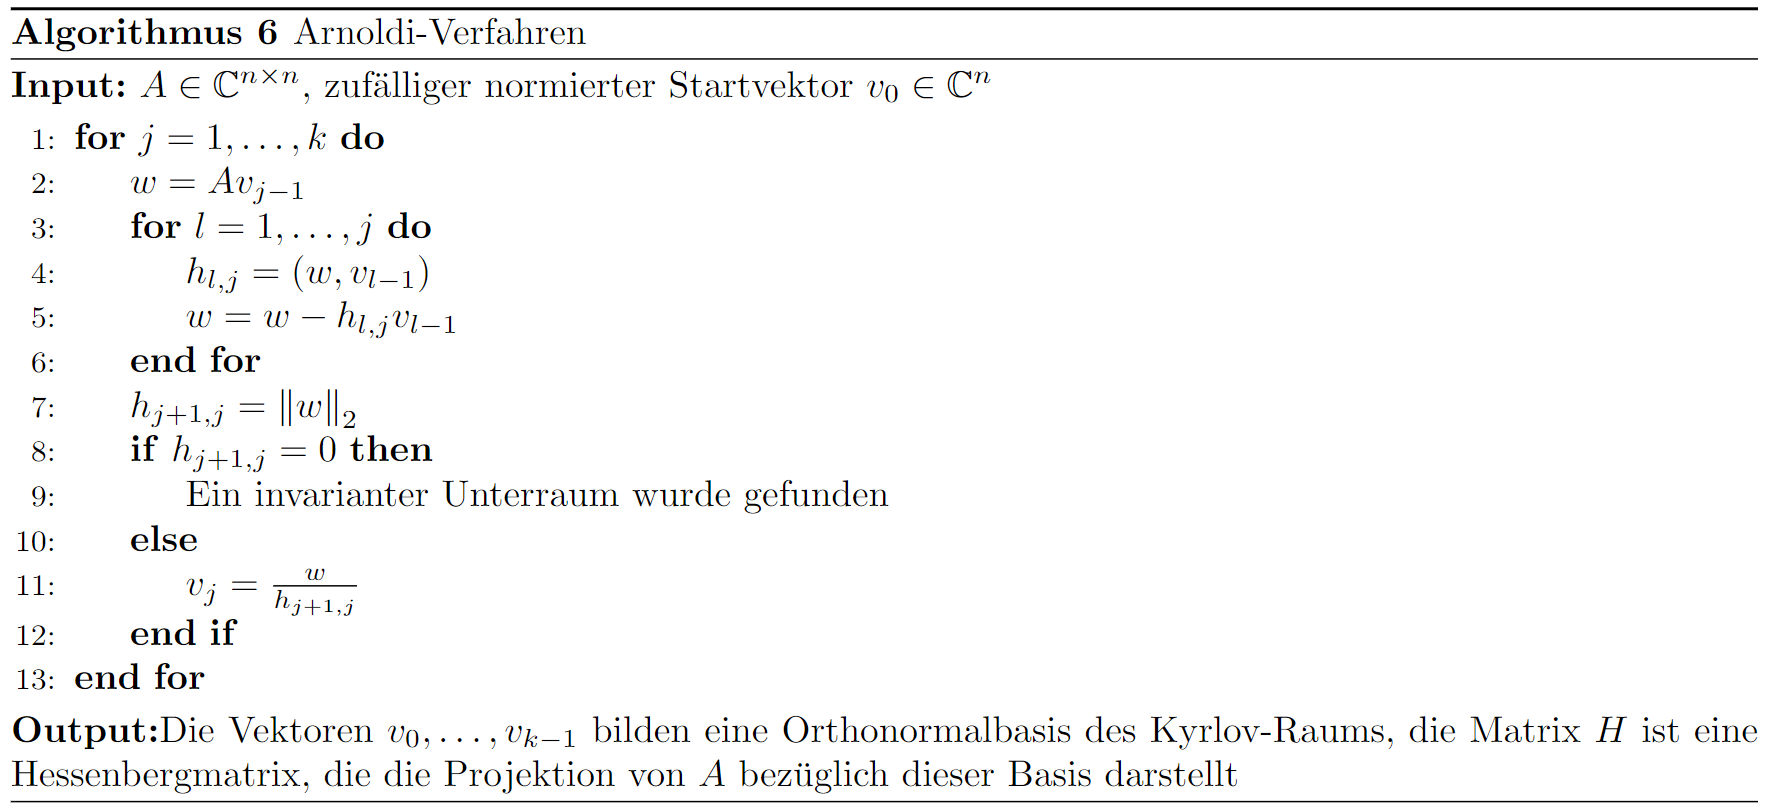

In [50]:
def arnoldi(A, dim, k = 0):                    #Hier wird die Dimension extra übergeben, da A nicht zwingend eine Matrix sein muss, sondern nur als Funktion übergeben werden kann
    n = dim
    if k == 0:                                 #Falls nicht näher angegeben, werden alle Eigenwerte berechnet
        k = n
        
    v0 = np.random.rand(n)                     #Random-Startvektor wird initialisiert
    v = [v0/np.linalg.norm(v0)]                #Der Vektor wird zusätzlich normiert
    h = np.zeros((k,k))                        #h ist die neue Matrix die erstellt wird, entspricht T aus dem Lanczos-Verfahern
    
    for j in range(k):
        w = A(v[j])                            #Entspricht A@v[j]
        for l in range(j+1):                   #Schleife für Orthogonalisierung nach Gram-Schmidt
            h[l][j] = v[l].T.conj()@w          #Enstpricht v[l]*@w = (v[l], w)
            w = w - h[l][j]*v[l]               #Gram-Schmidt Orthogonalisierung
        if j < k-1:                            #Nur im letzten Druchlauf nicht erfüllt
            h[j+1][j] = np.sqrt(w.T.conj()@w)  #sqrt((w,w)) zur Normierung
            if abs(h[j+1][j]) < 1e-14:         #Invarianter Unterraum gefunden, entspricht delta-Bedingung aus Lanczos
                return QR_hesse(h[:j+1,:j+1])  #Eigenwertberechnung der kleineren Matrix
            else:
                v.append(w/h[j+1][j])          #Normierter Vektor wird hinzugefügt
    
    return QR_hesse(h)

In [51]:
error_arnoldi = [0]*k


for i in range(k):
    error_arnoldi[i] = outsource.selective_error(np.array(arnoldi(lambda x: mat_lan_2@x, n_dim, dim_kyrlov[i])[1]), eigvalues, nr_approx_eigs)

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


<IPython.core.display.Javascript object>


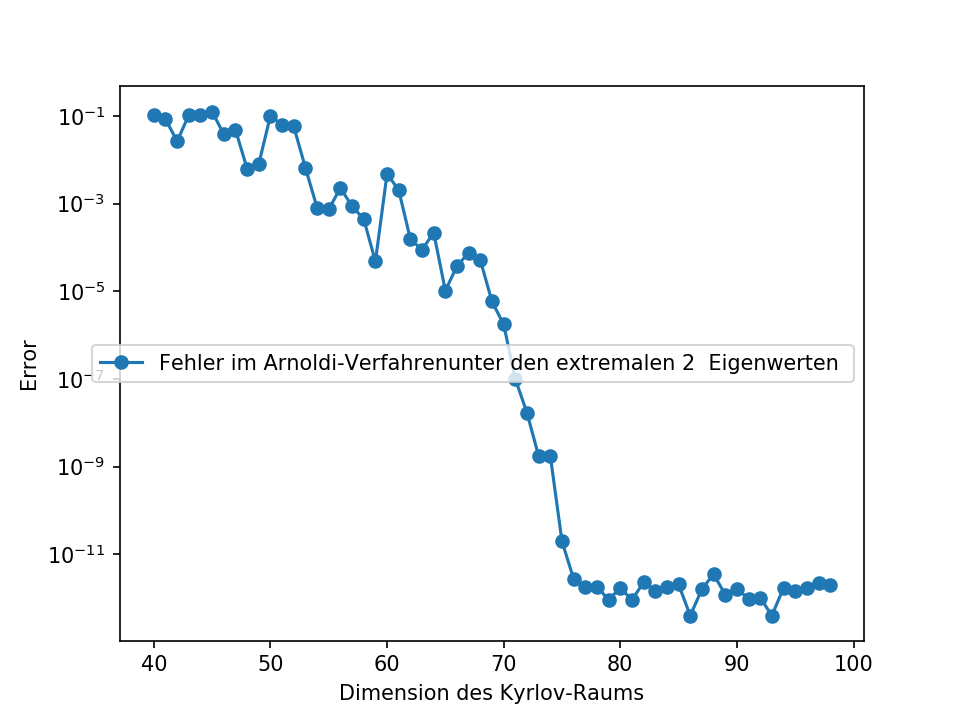

In [61]:
%matplotlib notebook

plt.semilogy(dim_kyrlov, error_arnoldi, '-o', label = "Fehler im Arnoldi-Verfahrenunter den extremalen {nr}  Eigenwerten ".format(nr = nr_approx_eigs*2))

plt.xlabel("Dimension des Kyrlov-Raums")
plt.ylabel("Error")
plt.legend()
plt.show()

## Applying the Arnoldi-Iteration to get eigenvalues of $-\Delta$ 

### Setting Ngsolve Parameters

In [53]:
a = 2                             # Length of rectangle in x direction 
b = 1                             # Length of rectangle in y direction 
R = 1                             # Radius of circle

maxh = 0.05                       # Mesh-size
order = 4                         # Order of Polynomials
nr_eigs = [50, 75, 100, 200]      # Number of Eigenvalues to approximate

### Create rectangle via Netgen

In [54]:
geo = SplineGeometry()
geo.AddRectangle((0,0), (a,b), bcs=["b","r","t","l"])


mesh = Mesh(geo.GenerateMesh(maxh=maxh))
Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

### FES and the bilinear- and linearform

In [55]:
fes = H1(mesh, complex=True, order=order)

eigenvec = GridFunction(fes,multidim=nr_eigs)

u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm (fes)
a += SymbolicBFI (grad(u)*grad(v))

b = BilinearForm (fes)
b += SymbolicBFI (u*v)

a.Assemble()
b.Assemble()

A=a.mat
B=b.mat

### Generate Matrices

Aus der Finite-Elemente-Methode erhalten wir das verallgemeinerte Eigenwertproblem

$$
Ax_h = \lambda_h B x_h
$$

wobei $A,B \in \mathbb{R}^{n \times n}$ symmetrisch sind. Mit einem Shift $\rho_h \in \mathbb{R}$, der kein Eigenwert ist, kann man das Problem in ein einfaches Eigenwertproblem der Art

$$
(A -\rho_hB)^{-1}Bx_h = \mu_h x_h
$$

überführen. Die Eigenwerte des verallgemeinerten Eigenwertproblems erhält man schließlich durch

$$
\lambda_h = \frac{1}{\mu_h} + \rho_h
$$

Hier benötigen wir schließlich das Arnoldi-Verfahren, da die Matrix $(A -\rho_hB)^{-1}B$ im Allgemeinen nicht mehr symmetrisch sein wird.

In [56]:
shift = 3

shifted = a.mat.CreateMatrix()                                            #Matrix A wird aus NGSolve gewonnen
shifted.AsVector().data = a.mat.AsVector() - (shift**2)*b.mat.AsVector()  #A-shift^2 B
invshifted = shifted.Inverse(freedofs=fes.FreeDofs())                     #Inverse der Matrix wird berechnet

tmp1 = eigenvec.vec.CreateVector()
tmp2 = eigenvec.vec.CreateVector()

def matvec(v):                                                            #Realisiert die Multiplikation der   
    tmp1.FV().NumPy()[:] = v                                              #verallgemeinerten Matrix mit Vektor v
    tmp2.data = b.mat * tmp1
    tmp1.data = invshifted * tmp2
    return tmp1.FV().NumPy()

A = scipy.sparse.linalg.LinearOperator( (a.mat.height,a.mat.width), matvec)

print("Dimension der Matrix =", a.mat.height)

Dimension der Matrix = 15137


### Eigenvalues via arnoldi

Wir können nun die Eigenwerte mit dem Arnoldi-Verfahren approximieren.

In [57]:
mu_1 = arnoldi(A, a.mat.height, nr_eigs[0])[1]                  #Anwenden des Arnoldi-Verfahrens

for i in range(len(mu_1)):                                      #Rückshiften der Eigenwerte
    mu_1[i] = shift**2+1/mu_1[i]
lamsquared_1 = mu_1                                             #Umbenennung
lamsquared_1 = sorted(lamsquared_1)                             #Eigenwerte werden aufsteigend sortiert 
lams_1= [sqrt(l) for l in lamsquared_1]                         #Wurzeln der Eigenwerte werden berechnet
print("resonances:")
for i in range (1,10):
    print(i,": ",lams_1[i], " squared: ", lamsquared_1[i])  


C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


resonances:
1 :  1.57079632679491  squared:  2.467401100272382
2 :  3.14159265358981  squared:  9.869604401089463
3 :  3.1415926535898167  squared:  9.869604401089505
4 :  3.5124073655203936  squared:  12.337005501361912
5 :  4.442882938158537  squared:  19.73920880218023
6 :  4.712388980384988  squared:  22.20660990245387
7 :  5.6635866995708914  squared:  32.0762143035563
8 :  6.283185307183087  squared:  39.47841760440143
9 :  6.283185307183103  squared:  39.47841760440163


In [58]:
mu_2 = arnoldi(A, a.mat.height, nr_eigs[1])[1]
mu_3 = arnoldi(A, a.mat.height, nr_eigs[2])[1]
mu_4 = arnoldi(A, a.mat.height, nr_eigs[3])[1]

for i in range(len(mu_2)):
    mu_2[i] = shift**2+1/mu_2[i]

for i in range(len(mu_3)):
    mu_3[i] = shift**2+1/mu_3[i]

for i in range(len(mu_4)):
    mu_4[i] = shift**2+1/mu_4[i]
    
lamsquared_2 = mu_2
lamsquared_3 = mu_3
lamsquared_4 = mu_4

lamsquared_2 = sorted(lamsquared_2)
lamsquared_3 = sorted(lamsquared_3)
lamsquared_4 = sorted(lamsquared_4)

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


### Calculating the exact eigenvalues

In [126]:
def exact_eigvals(n,m):                                         #Berechnet die exakten Eigenwerte für das Gebiet
    return np.pi**2*((n**2)/4 + m**2)

exact_arr = []

for n in range(40):                                             #Array wird mit exakten Eigenwerten gefüllt
    for m in range(20):
        exact_arr.append(exact_eigvals(n,m))
        
exact_arr = sorted(exact_arr)                                   #Sortierung der Eigenwerte
print(len(exact_arr))

800


<IPython.core.display.Javascript object>


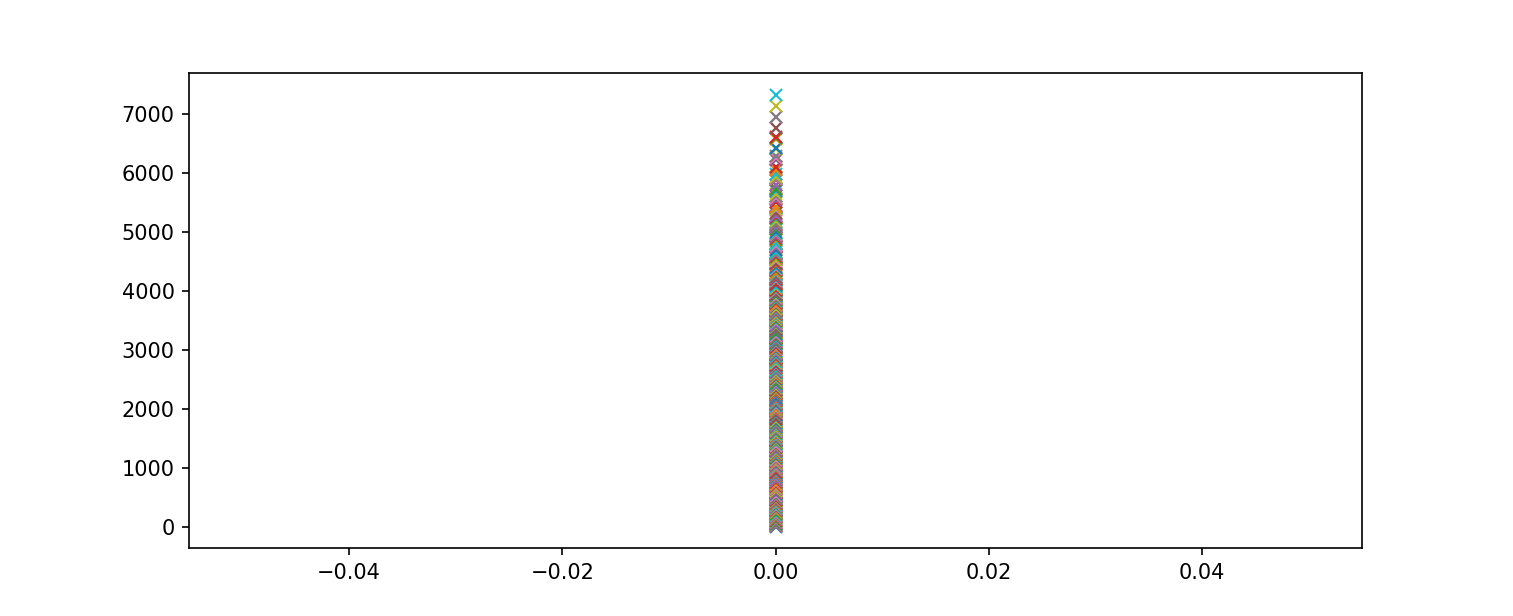

In [136]:
%matplotlib notebook

for k in range(len(exact_arr)):
    plt.plot(0, exact_arr[k], 'x')


plt.show()

### Plotting the error of the first few eigenvalues

<IPython.core.display.Javascript object>


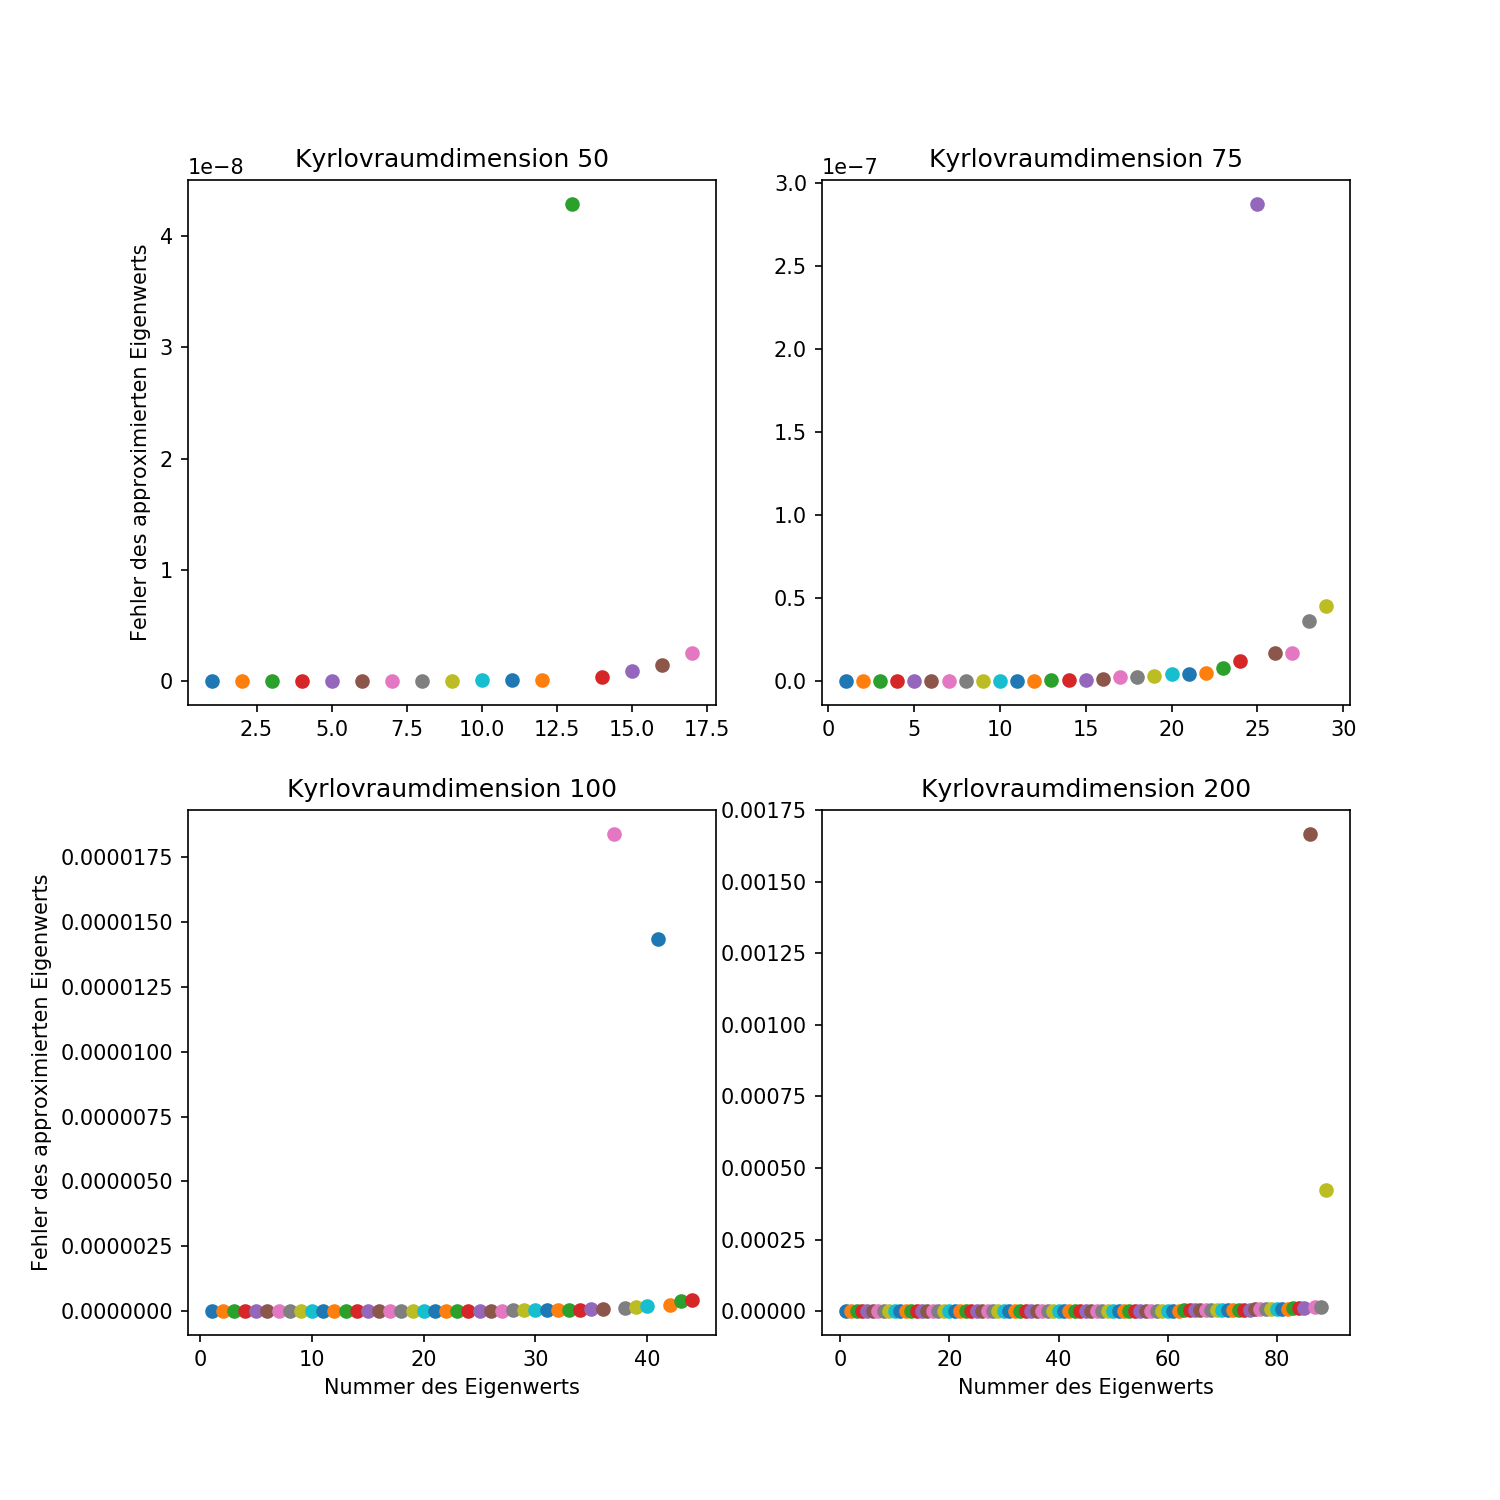

In [128]:
%matplotlib notebook

fig, axes  = plt.subplots(2, 2, figsize = (10,10))

for k in range(1,int(nr_eigs[0]*0.37)):
    axes[0][0].plot(k,abs(exact_arr[k]-lamsquared_1[k]), 'o')

for k in range(1,int(nr_eigs[1]*0.40)):
    axes[0][1].plot(k,abs(exact_arr[k]-lamsquared_2[k]), 'o')

for k in range(1,int(nr_eigs[2]*0.45)):
    axes[1][0].plot(k,abs(exact_arr[k]-lamsquared_3[k]), 'o')

for k in range(1,int(nr_eigs[3]*0.45)):
    axes[1][1].plot(k,abs(exact_arr[k]-lamsquared_4[k]), 'o')


axes[0][0].set_title("Kyrlovraumdimension {dim}".format(dim = nr_eigs[0]))
axes[0][0].set_ylabel("Fehler des approximierten Eigenwerts")
axes[0][1].set_title("Kyrlovraumdimension {dim}".format(dim = nr_eigs[1]))
axes[1][0].set_title("Kyrlovraumdimension {dim}".format(dim = nr_eigs[2]))
axes[1][0].set_xlabel("Nummer des Eigenwerts")
axes[1][0].set_ylabel("Fehler des approximierten Eigenwerts")
axes[1][1].set_title("Kyrlovraumdimension {dim}".format(dim = nr_eigs[3]))
axes[1][1].set_xlabel("Nummer des Eigenwerts")
plt.show()